In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from fairlearn.metrics import MetricFrame
from sklearn import metrics as skm
import seaborn as sns
import os.path as path
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import os, csv, shapely, shapely.wkt, descartes, geopy, pickle, cloudpickle
from itertools import repeat
pd.set_option('display.max_rows', 10)
# sns.set()
# sns.color_palette("ch:s=.25,rot=-.25")
np.set_printoptions(suppress=True)
# pd.options.display.float_format = '{:.2f}'.format


Bad key "text.kerning_factor" on line 4 in
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# specify number of stations want to increase
NUM_STATIONS_INC = 1

In [3]:
# specify dir
CITY = "N_"
save_dir = CITY + 'reg_res/'
save_dir_preprocess = os.path.join(save_dir, CITY + 'preprocess_fig/')
save_dir_models = os.path.join(save_dir, CITY + 'model_res/') 
save_dir_forecast = os.path.join(save_dir, CITY + 'forecast/')
save_dir_fairst = os.path.join(save_dir, CITY + 'fairst/')


In [4]:
# load unmitigated random forest
with open(os.path.join(save_dir_models, CITY + "random_forest.pkl"), 'rb') as file:  
    rf_best = pickle.load(file)

# load exponentiated gradient
with open(os.path.join(save_dir_models, CITY + "exp_grad.pkl"), 'rb') as file:  
    eg_best = cloudpickle.load(file)

# load grid search
with open(os.path.join(save_dir_models, CITY + "grid_search.pkl"), 'rb') as file:  
    gs_best = pickle.load(file)

In [5]:
DATA_PATH = 'preprocess/'
df_census = pd.read_csv(DATA_PATH + "df_census.csv", index_col = 0)
df_weather = pd.read_csv(DATA_PATH + "df_weather_sort.csv", index_col = 0)
X_train = pd.read_csv(os.path.join(save_dir_forecast, CITY + "X_train.csv"), index_col = 0)
for row,col in df_census.iterrows():
    df_census.at[row, 'geometry'] = shapely.wkt.loads(df_census.loc[row]['geometry'])

In [6]:
df_geo = df_census[["cell_num", "geometry", "centroid"]]

In [7]:
# training set
df_census["income_group"] = 0
for row, col in df_census.iterrows():
    if df_census.loc[row]["median_hh_income"] > 50000:
        df_census.at[row, "income_group"] = 1
df_census.drop(columns = ["median_hh_income"], inplace = True)

In [8]:
df_census.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3957 entries, 0 to 3956
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cell_num                       3957 non-null   int64  
 1   geometry                       3957 non-null   object 
 2   centroid                       3957 non-null   object 
 3   stations                       3957 non-null   int64  
 4   stations_id_list               602 non-null    object 
 5   census_id                      3957 non-null   int64  
 6   total_population               3335 non-null   float64
 7   total_housing_units            3335 non-null   float64
 8   population_over_16             3335 non-null   float64
 9   population_over_16_in_labor    3335 non-null   float64
 10  population_over_16_employed    3335 non-null   float64
 11  population_over_16_unemployed  3335 non-null   float64
 12  num_works_over_16              3335 non-null   f

In [9]:
# duplicate rows 
df_forc = pd.DataFrame(np.repeat(df_census.values, 12, axis=0))
df_forc.columns = df_census.columns
df_forc = df_forc.astype(df_census.dtypes)

In [10]:
# load 2019 weather
# attach weather & month
df_weather_19 = df_weather[df_weather.year == 2019]
for index, col in df_forc.iterrows():
    curr_month = index%12 + 1
    
    df_forc.at[index, "month"] = curr_month
    df_forc.at[index, "temp"] = df_weather_19[df_weather_19.month == curr_month].temp.values[0]

df_forc.month = df_forc.month.astype(int)


In [11]:
# save cell_num
cell_num = df_forc["cell_num"]
df_forc.drop(columns = "cell_num", inplace = True)


In [12]:
features_col = ['month', 'stations', 
               'total_population', 'total_housing_units', 'population_over_16_employed',
               'population_over_16_unemployed', 'num_works_over_16',
               'car_truck_van_alone', 'car_truck_van_carpooled', 'public_transit',
               'walked', 'other_means', 'wfh', 'mean_travel_time_to_work',
                'walk_score', 'transit_score', 'bike_score', 'nearby_bus',
                'nearby_rail', 'nearby_other', 'nearby_routes', 'temp',
               'income_group']

In [13]:
df_forc = df_forc[features_col]
df_forc

,month,stations,total_population,total_housing_units,population_over_16_employed,population_over_16_unemployed,num_works_over_16,car_truck_van_alone,car_truck_van_carpooled,public_transit,...,mean_travel_time_to_work,walk_score,transit_score,bike_score,nearby_bus,nearby_rail,nearby_other,nearby_routes,temp,income_group
0,1,0,6228.0,2158.0,2765.0,70.0,2750.0,1941.0,251.0,480.0,...,43.6,36.0,57.0,43.0,11,2,0,13,32.5,1
1,2,0,6228.0,2158.0,2765.0,70.0,2750.0,1941.0,251.0,480.0,...,43.6,36.0,57.0,43.0,11,2,0,13,36.2,1
2,3,0,6228.0,2158.0,2765.0,70.0,2750.0,1941.0,251.0,480.0,...,43.6,36.0,57.0,43.0,11,2,0,13,41.7,1
3,4,0,6228.0,2158.0,2765.0,70.0,2750.0,1941.0,251.0,480.0,...,43.6,36.0,57.0,43.0,11,2,0,13,55.5,1
4,5,0,6228.0,2158.0,2765.0,70.0,2750.0,1941.0,251.0,480.0,...,43.6,36.0,57.0,43.0,11,2,0,13,62.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47479,8,0,5073.0,1837.0,2584.0,107.0,2524.0,1656.0,314.0,406.0,...,39.2,83.0,56.0,54.0,13,0,0,13,75.5,1
47480,9,0,5073.0,1837.0,2584.0,107.0,2524.0,1656.0,314.0,406.0,...,39.2,83.0,56.0,54.0,13,0,0,13,70.4,1
47481,10,0,5073.0,1837.0,2584.0,107.0,2524.0,1656.0,314.0,406.0,...,39.2,83.0,56.0,54.0,13,0,0,13,59.9,1
47482,11,0,5073.0,1837.0,2584.0,107.0,2524.0,1656.0,314.0,406.0,...,39.2,83.0,56.0,54.0,13,0,0,13,43.9,1


In [14]:
df_forc = df_forc[X_train.columns]

In [15]:
df_forc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47484 entries, 0 to 47483
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   month                          47484 non-null  int64  
 1   stations                       47484 non-null  int64  
 2   total_population               40020 non-null  float64
 3   total_housing_units            40020 non-null  float64
 4   population_over_16_employed    40020 non-null  float64
 5   population_over_16_unemployed  40020 non-null  float64
 6   num_works_over_16              40020 non-null  float64
 7   car_truck_van_alone            40020 non-null  float64
 8   car_truck_van_carpooled        40020 non-null  float64
 9   public_transit                 40020 non-null  float64
 10  walked                         40020 non-null  float64
 11  other_means                    40020 non-null  float64
 12  wfh                            40020 non-null 

### prediction

In [16]:
# increase stations by NUM_STATIONS_INC, then scale
df_forc_new = df_forc.copy()
df_forc_new["stations"] += NUM_STATIONS_INC

In [17]:
df_forc_new = df_forc_new.fillna(df_forc_new.mean())

In [18]:
## new prediction
new_pred_random_forest = rf_best.predict(df_forc_new)
new_pred_exp_grad = eg_best.predict(df_forc_new, random_state = 42)
new_pred_grid_search = gs_best.predict(df_forc_new)

In [19]:
pred_df = cell_num.to_frame()
pred_df["month"] = df_forc_new["month"]
pred_df["income_group"] = df_forc_new["income_group"]
# pred_df["stations_added"] = df_forc_new["stations"]

In [20]:
pred_df["stations_added"] = df_forc_new["stations"]

In [21]:
cell_num2stations_df = pred_df.groupby("cell_num").mean().reset_index()[["cell_num", "stations_added"]]
# cell_num2stations_df.stations_added = cell_num2stations_df.stations_added.astype(int)
cell_num2stations_df

,cell_num,stations_added
0,94,1.0
1,95,1.0
2,186,1.0
3,187,1.0
4,188,1.0
...,...,...
3952,11216,1.0
3953,11305,1.0
3954,11306,1.0
3955,11307,1.0


In [22]:
pred_df["new_pred_random_forest"] = new_pred_random_forest
pred_df["new_pred_exp_grad"] = new_pred_exp_grad
pred_df["new_pred_grid_search"] = new_pred_grid_search

In [23]:
pred_df

,cell_num,month,income_group,stations_added,new_pred_random_forest,new_pred_exp_grad,new_pred_grid_search
0,94,1,1,1,200.23,177.31,278.46
1,94,2,1,1,203.10,184.84,291.99
2,94,3,1,1,261.64,228.93,310.37
3,94,4,1,1,659.06,544.14,733.69
4,94,5,1,1,739.83,756.42,759.25
...,...,...,...,...,...,...,...
47479,11308,8,1,1,1008.72,997.39,926.06
47480,11308,9,1,1,930.56,912.49,765.53
47481,11308,10,1,1,708.94,742.18,707.43
47482,11308,11,1,1,397.65,346.28,486.01


In [24]:
pred_df_yearly = pred_df.groupby("cell_num").sum().reset_index().drop(columns = ["month"])
pred_df_yearly

,cell_num,income_group,stations_added,new_pred_random_forest,new_pred_exp_grad,new_pred_grid_search
0,94,12,12,7126.16,6689.63,7716.95
1,95,12,12,7087.32,6562.02,7644.62
2,186,12,12,5769.63,6373.48,7297.39
3,187,12,12,6132.38,6643.49,7388.37
4,188,12,12,7115.30,6569.52,7644.62
...,...,...,...,...,...,...
3952,11216,0,12,6325.73,6596.30,7667.90
3953,11305,12,12,8459.44,8185.19,8037.46
3954,11306,12,12,7001.51,6804.04,7346.88
3955,11307,12,12,6985.67,6807.40,7377.61


In [25]:
pred_df_yearly = pred_df_yearly.merge(cell_num2stations_df, on = "cell_num", how = 'left')


In [26]:
pred_df_yearly_geo = pred_df_yearly.merge(df_geo, on = "cell_num", how = "left")
pred_df_yearly_geo = gpd.GeoDataFrame(pred_df_yearly_geo, crs='EPSG:2956', geometry='geometry')


In [27]:
pred_df_yearly_geo["income_group"] = pred_df_yearly_geo["income_group"].apply(lambda x: "high_income" if x == 12 else "low_income")

In [28]:
pred_df_yearly_geo

,cell_num,income_group,stations_added_x,new_pred_random_forest,new_pred_exp_grad,new_pred_grid_search,stations_added_y,geometry,centroid
0,94,high_income,12,7126.16,6689.63,7716.95,1.0,"POLYGON ((-74.25559 40.50071, -74.25559 40.505...",POINT (-74.2532975057314 40.50300978280572)
1,95,high_income,12,7087.32,6562.02,7644.62,1.0,"POLYGON ((-74.25559 40.50531, -74.25559 40.509...",POINT (-74.2532975057314 40.50760057134288)
2,186,high_income,12,5769.63,6373.48,7297.39,1.0,"POLYGON ((-74.25100 40.49612, -74.25100 40.500...",POINT (-74.24870671719425 40.49841899426858)
3,187,high_income,12,6132.38,6643.49,7388.37,1.0,"POLYGON ((-74.25100 40.50071, -74.25100 40.505...",POINT (-74.24870671719425 40.50300978280572)
4,188,high_income,12,7115.30,6569.52,7644.62,1.0,"POLYGON ((-74.25100 40.50531, -74.25100 40.509...",POINT (-74.24870671719425 40.50760057134288)
...,...,...,...,...,...,...,...,...,...
3952,11216,low_income,12,6325.73,6596.30,7667.90,1.0,"POLYGON ((-73.70929 40.75321, -73.70929 40.757...",POINT (-73.70699366980966 40.75550315234901)
3953,11305,high_income,12,8459.44,8185.19,8037.46,1.0,"POLYGON ((-73.70470 40.73484, -73.70470 40.739...",POINT (-73.70240288127249 40.7371399982004)
3954,11306,high_income,12,7001.51,6804.04,7346.88,1.0,"POLYGON ((-73.70470 40.73944, -73.70470 40.744...",POINT (-73.70240288127249 40.74173078673755)
3955,11307,high_income,12,6985.67,6807.40,7377.61,1.0,"POLYGON ((-73.70470 40.74403, -73.70470 40.748...",POINT (-73.70240288127249 40.74632157527471)


### fairST

In [29]:
fairst_forecast_inc1 = pd.read_csv(os.path.join(save_dir_fairst,  "fairst_forecast_inc_1.csv"), index_col = 0)
fairst_forecast_inc2 = pd.read_csv(os.path.join(save_dir_fairst,  "fairst_forecast_inc_2.csv"), index_col = 0)

In [30]:
for row, col in fairst_forecast_inc1.iterrows():
    fairst_forecast_inc1.at[row, 'geometry'] = shapely.wkt.loads(fairst_forecast_inc1.loc[row]['geometry'])

In [31]:
for row, col in fairst_forecast_inc2.iterrows():
    fairst_forecast_inc2.at[row, 'geometry'] = shapely.wkt.loads(fairst_forecast_inc2.loc[row]['geometry'])

In [32]:
fairst_forecast_inc1 = gpd.GeoDataFrame(fairst_forecast_inc1, crs='EPSG:2956', geometry='geometry')
fairst_forecast_inc2 = gpd.GeoDataFrame(fairst_forecast_inc2, crs='EPSG:2956', geometry='geometry')

In [33]:
if NUM_STATIONS_INC == 1:
    fairst_forecast_inc = fairst_forecast_inc1
elif NUM_STATIONS_INC == 2: 
    fairst_forecast_inc = fairst_forecast_inc2

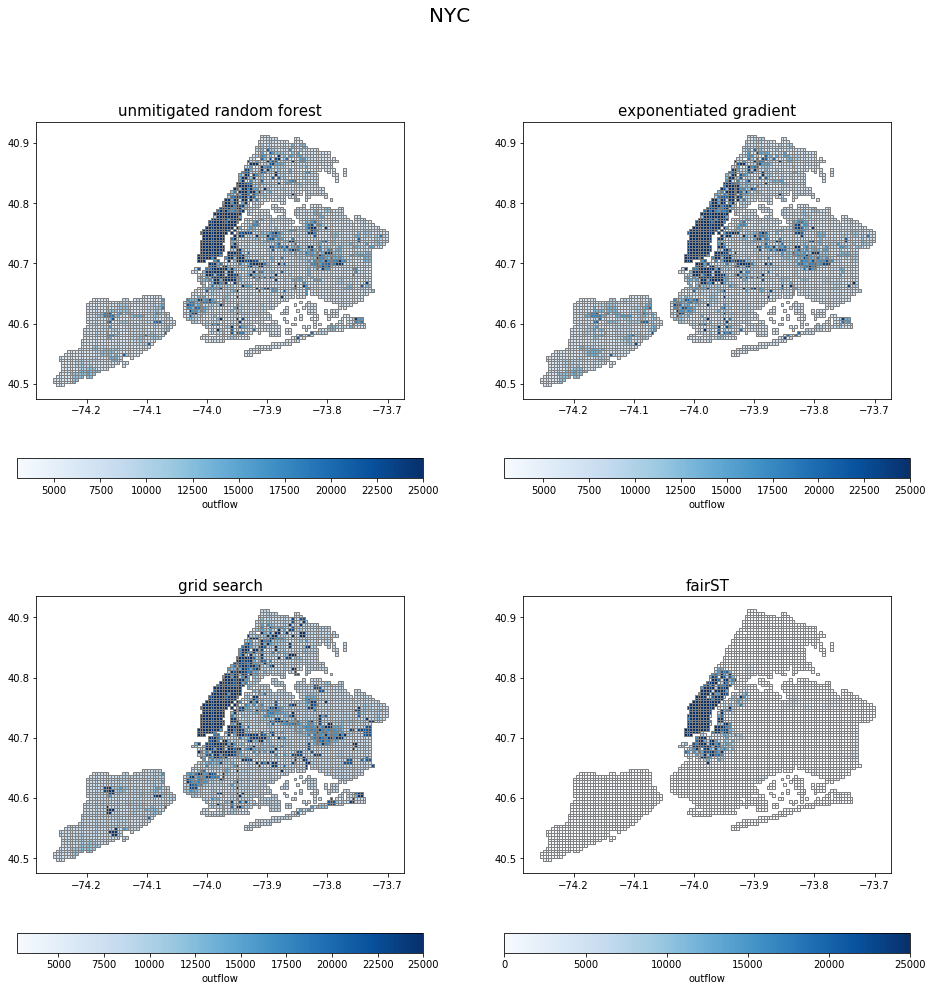

In [34]:
##### grid search
fig, axes = plt.subplots(2,2, figsize = (16, 16))

ax1=axes[0,0]
ax2=axes[0,1]
ax3=axes[1,0]
ax4=axes[1,1]

pred_df_yearly_geo.plot(column="new_pred_random_forest", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax1, vmax = 25000)
ax1.set_title("unmitigated random forest", fontsize=15)

pred_df_yearly_geo.plot(column="new_pred_exp_grad", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax2, vmax = 25000)
ax2.set_title("exponentiated gradient", fontsize=15)

pred_df_yearly_geo.plot(column="new_pred_grid_search", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax3, vmax = 25000)
ax3.set_title("grid search", fontsize=15)

fairst_forecast_inc.plot(column="outflow", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax4, vmax = 25000)

ax4.set_title("fairST", fontsize=15)

fig.suptitle('NYC', fontsize=20)

FIG_NAME = ("fig_after_inc_{}_station").format(NUM_STATIONS_INC)
plt.savefig(os.path.join(save_dir_forecast, CITY + FIG_NAME))

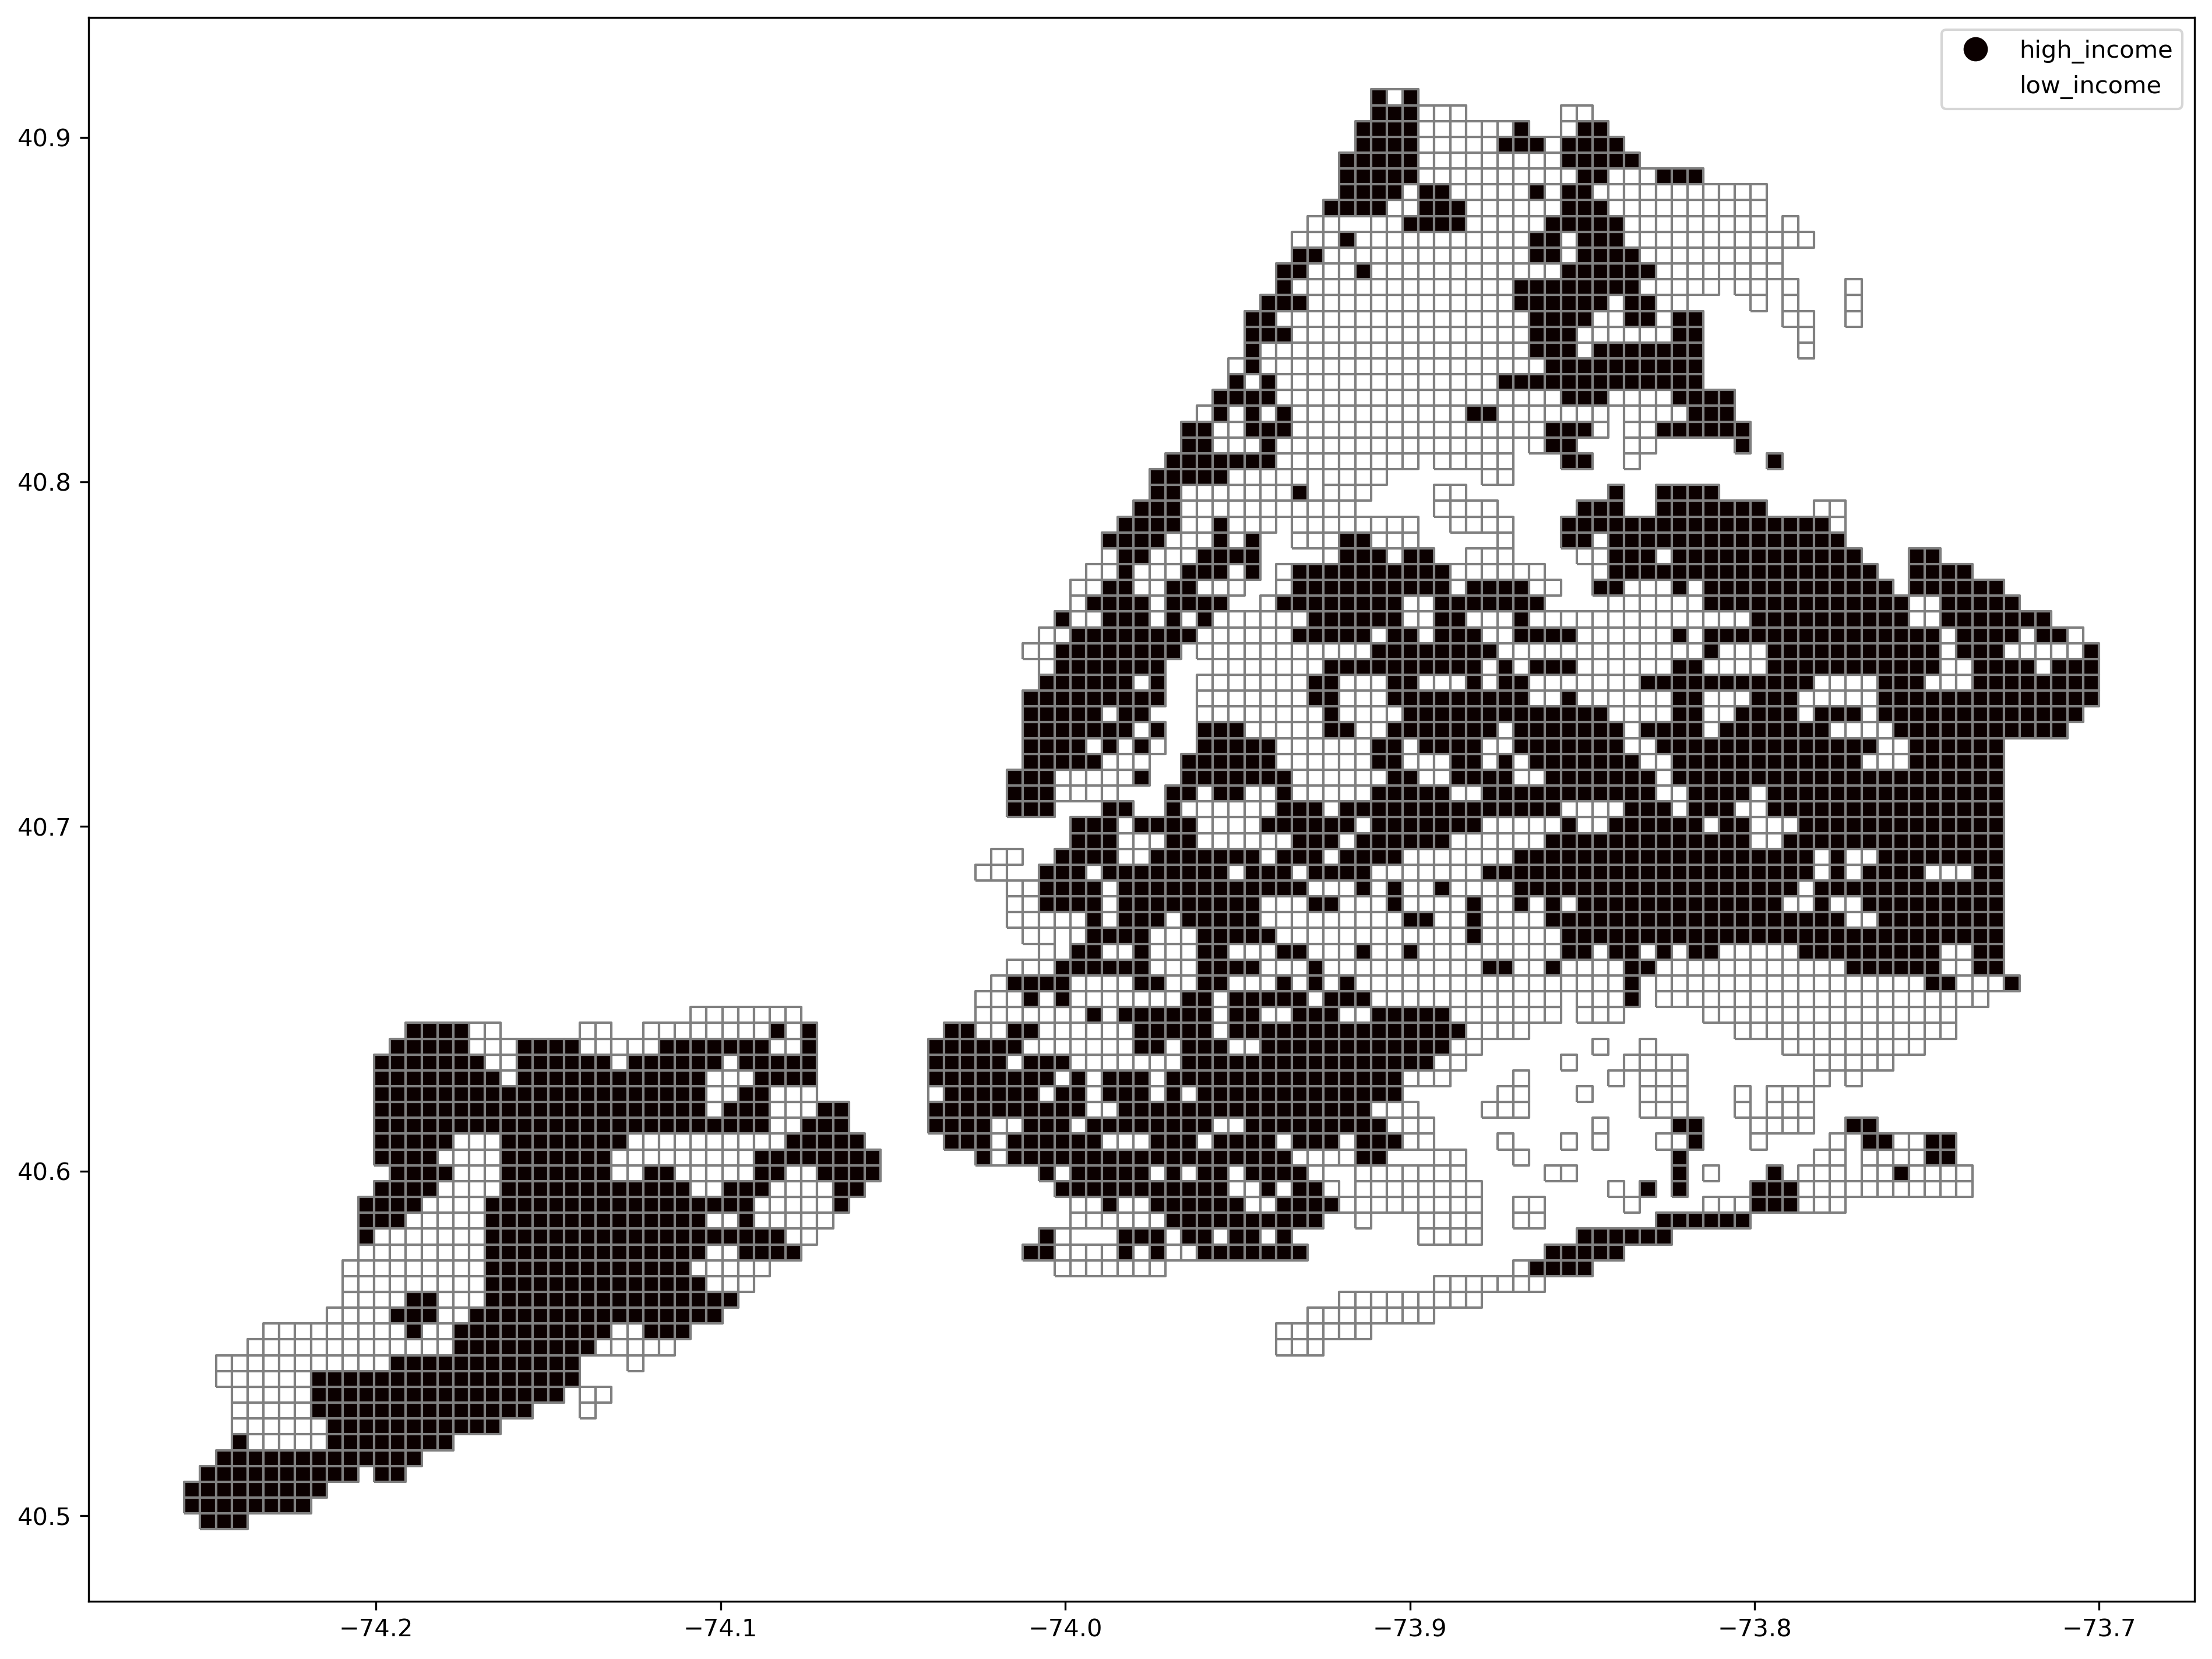

In [50]:
fig, axes = plt.subplots(figsize = (16, 12))
pred_df_yearly_geo.plot(column="income_group", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
                    legend = True, categorical = True, ax = axes)
# axes.set_title("NYC", fontsize=25)
FIG_NAME = "income_group_distribution"
plt.savefig(os.path.join(save_dir_forecast, CITY + FIG_NAME))
plt.savefig("nyc_income_all")

In [36]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

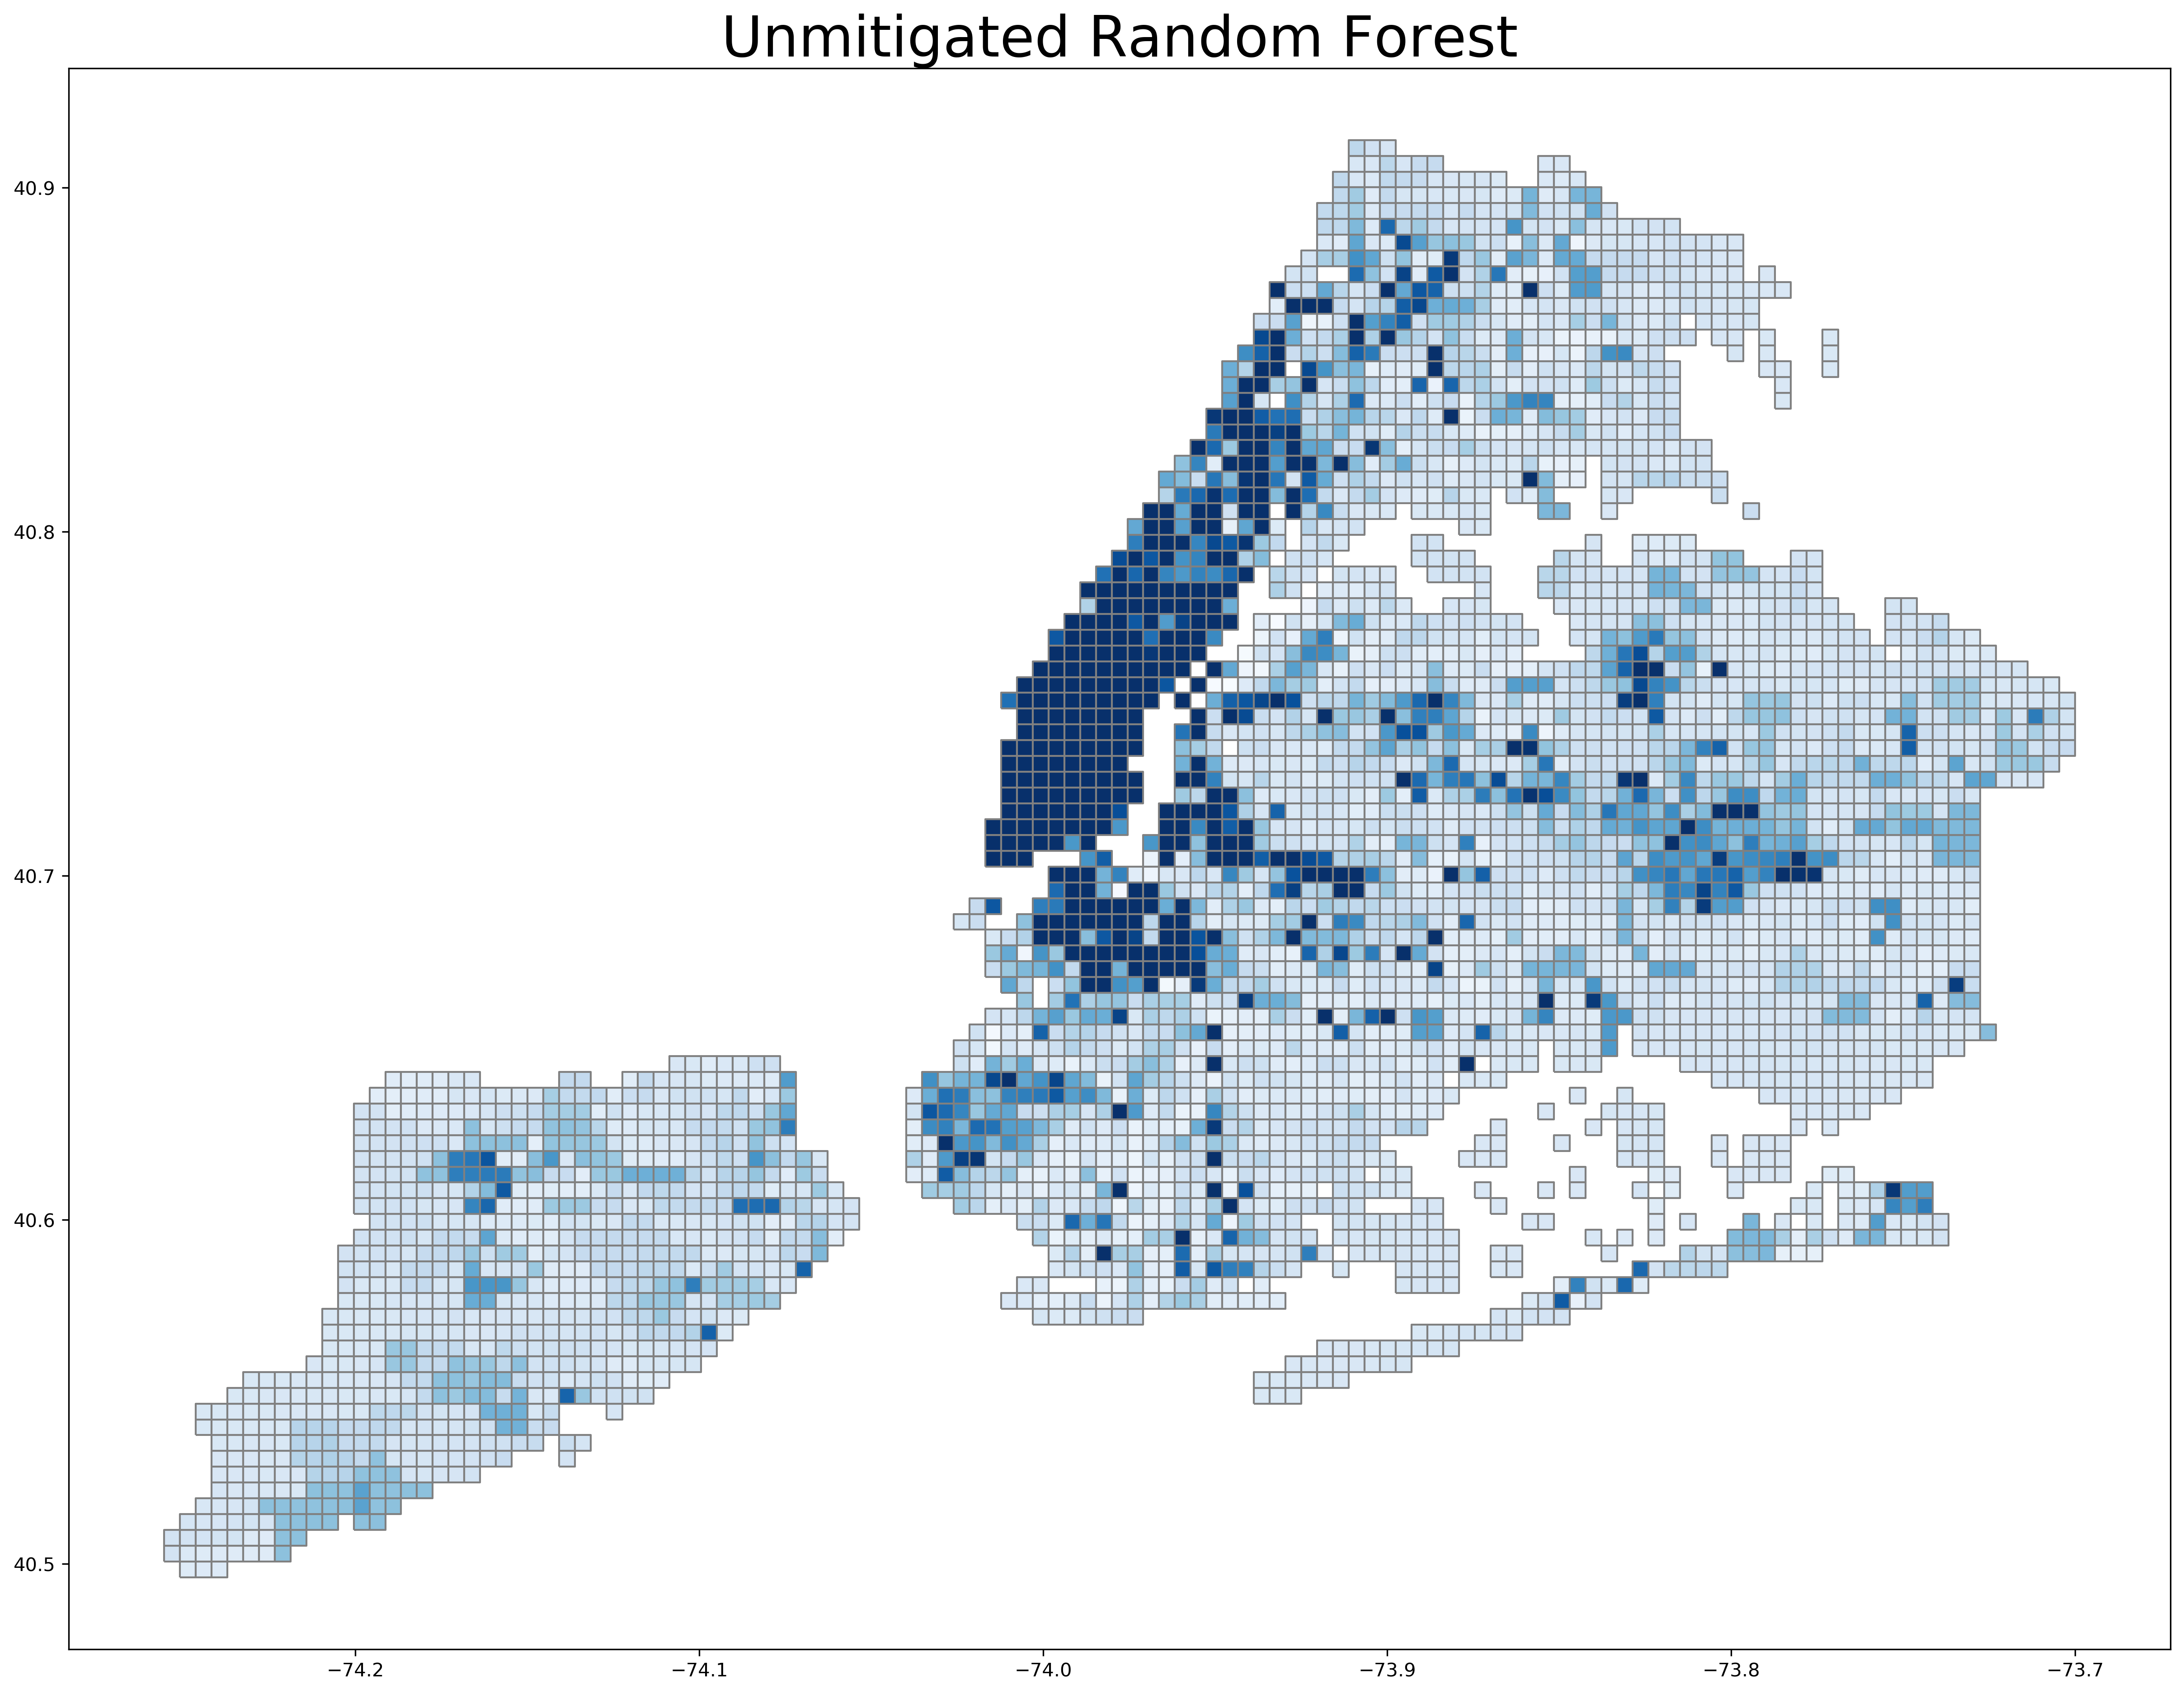

In [37]:
# plot 1
fig, axes = plt.subplots(figsize = (20, 16))
pred_df_yearly_geo.plot(column="new_pred_random_forest", cmap='Blues',edgecolor = "grey",
                    legend = False, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = axes, vmax = 25000)
axes.set_title("Unmitigated Random Forest", fontsize=30)
plt.savefig(os.path.join(save_dir_forecast, "FINAL_Unmitigated_" + CITY + FIG_NAME))

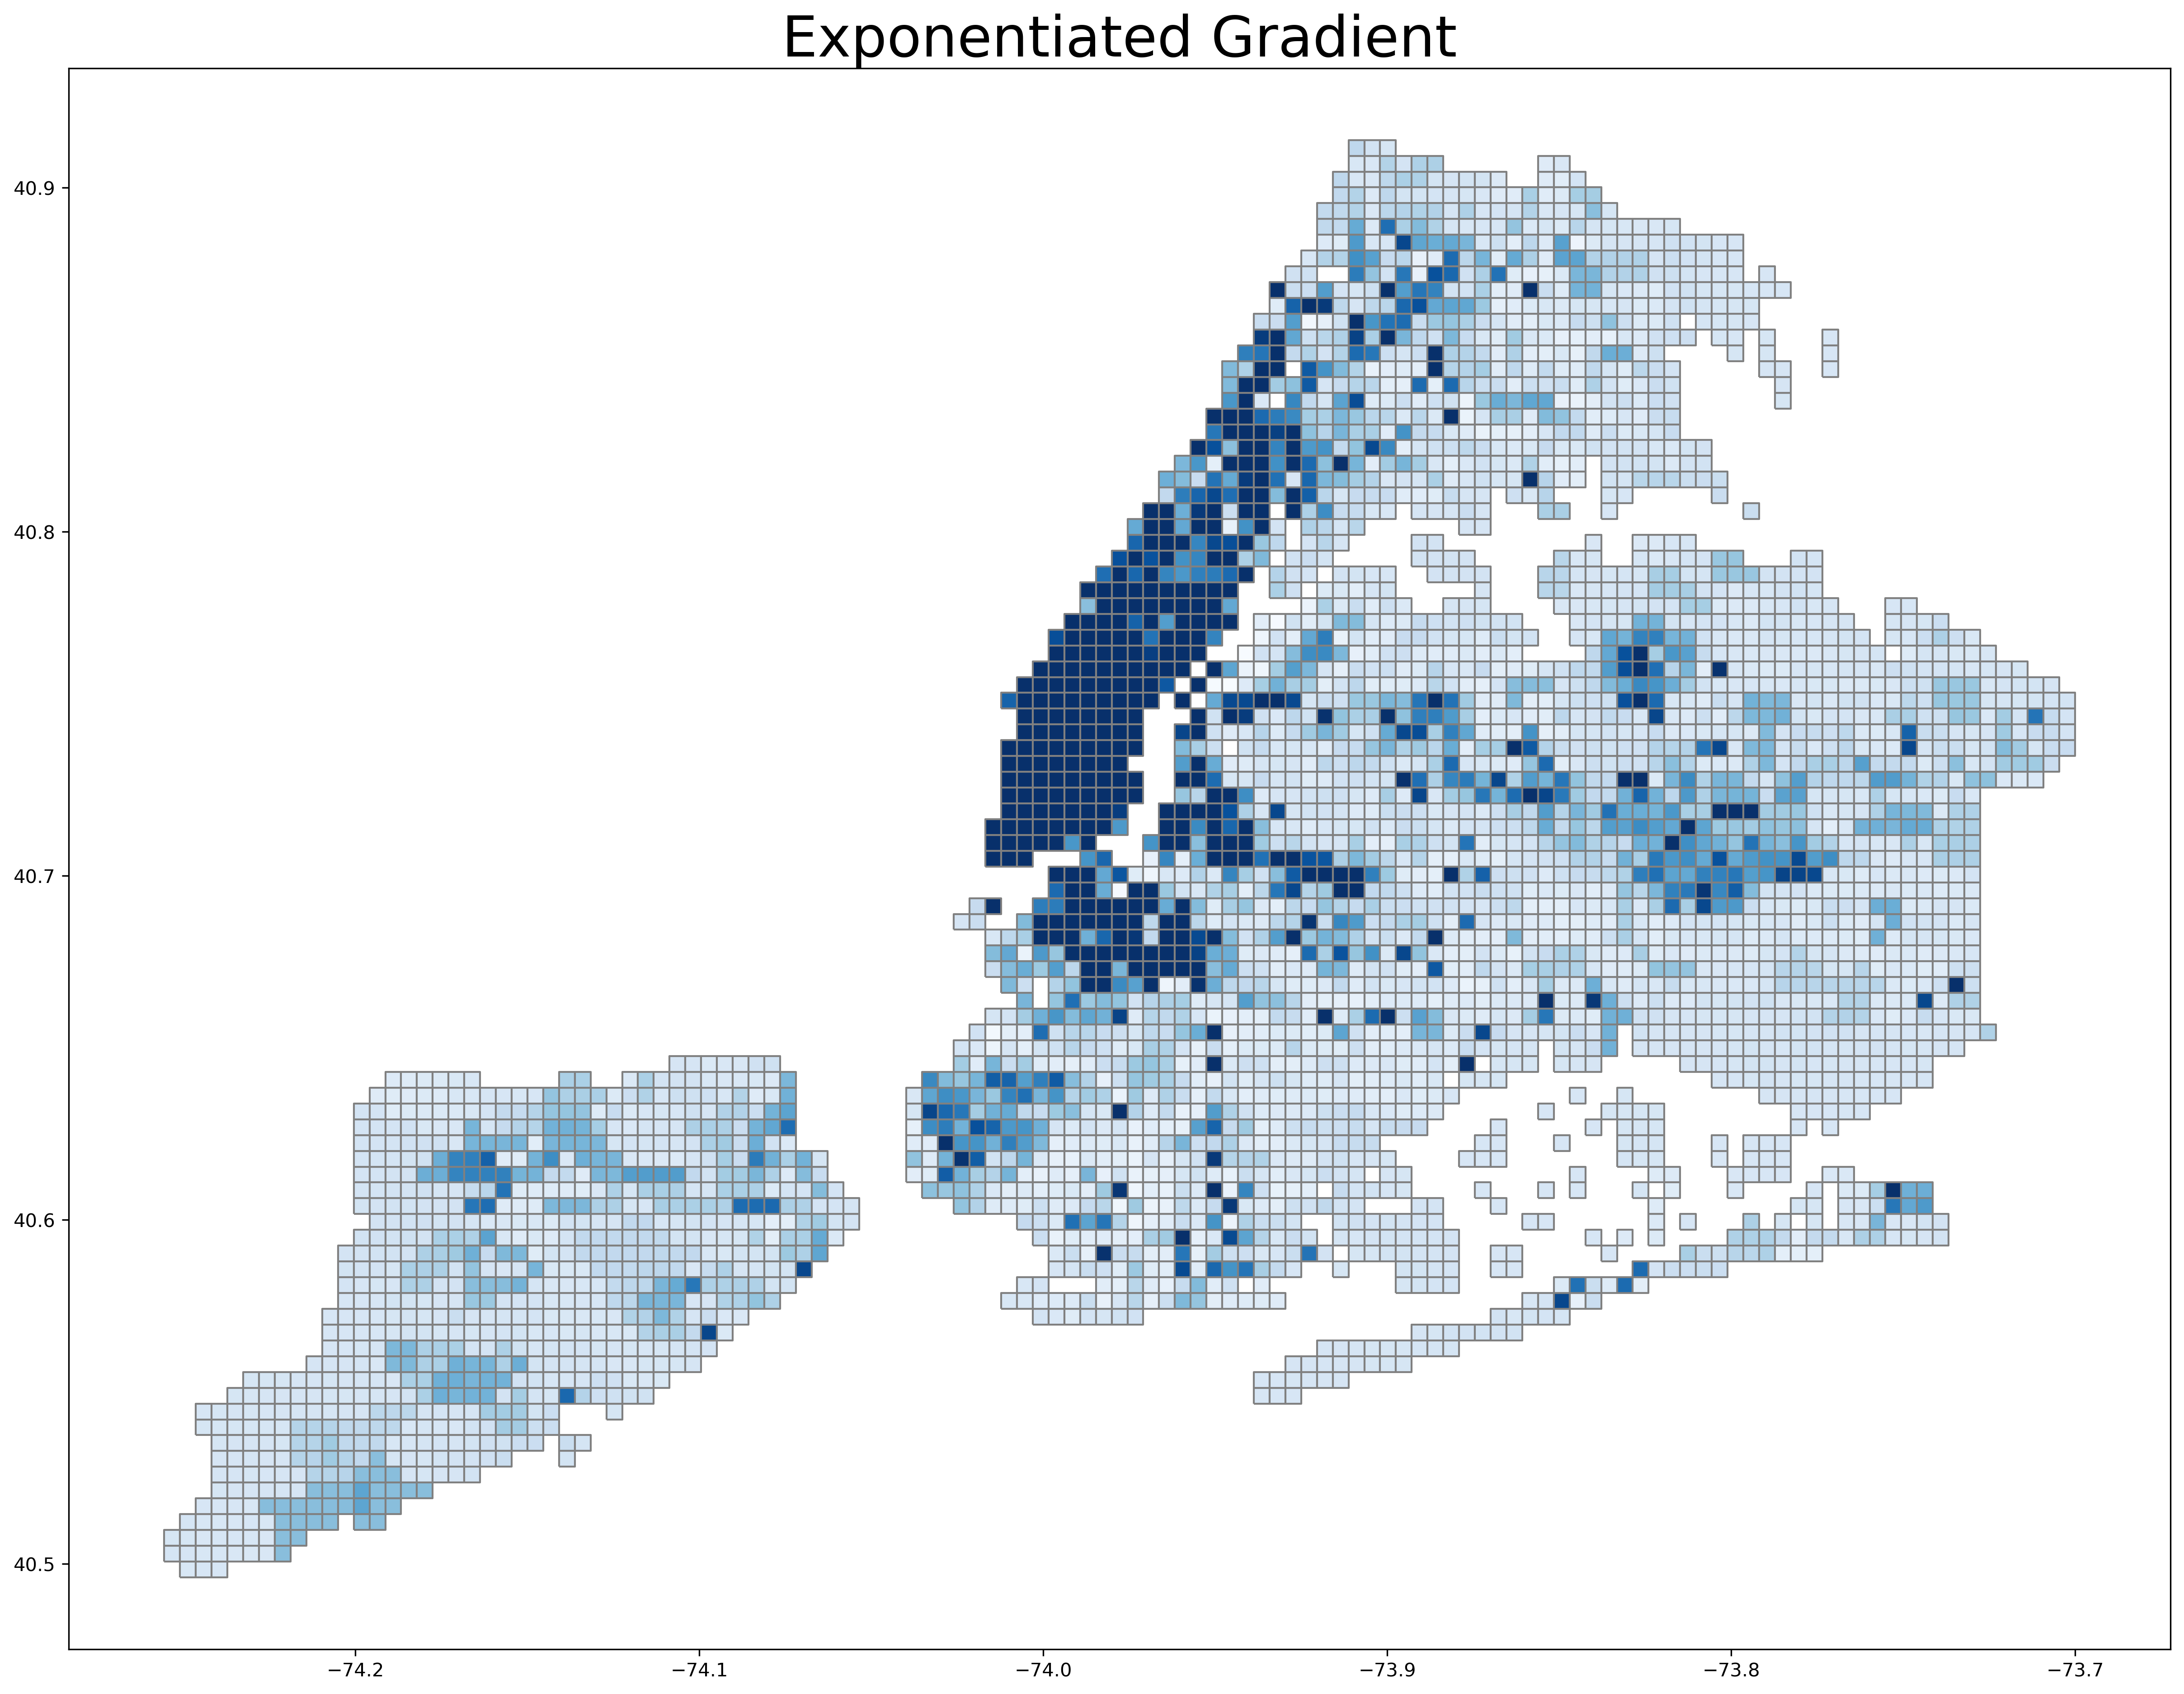

In [38]:
# plot 2
fig, axes = plt.subplots(figsize = (20, 16))

pred_df_yearly_geo.plot(column="new_pred_exp_grad", cmap='Blues',edgecolor = "grey", figsize=(12, 10),  
                    legend = False, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = axes, vmax = 25000)
axes.set_title("Exponentiated Gradient", fontsize=30)
plt.savefig(os.path.join(save_dir_forecast, "FINAL_EG_" + CITY + FIG_NAME))

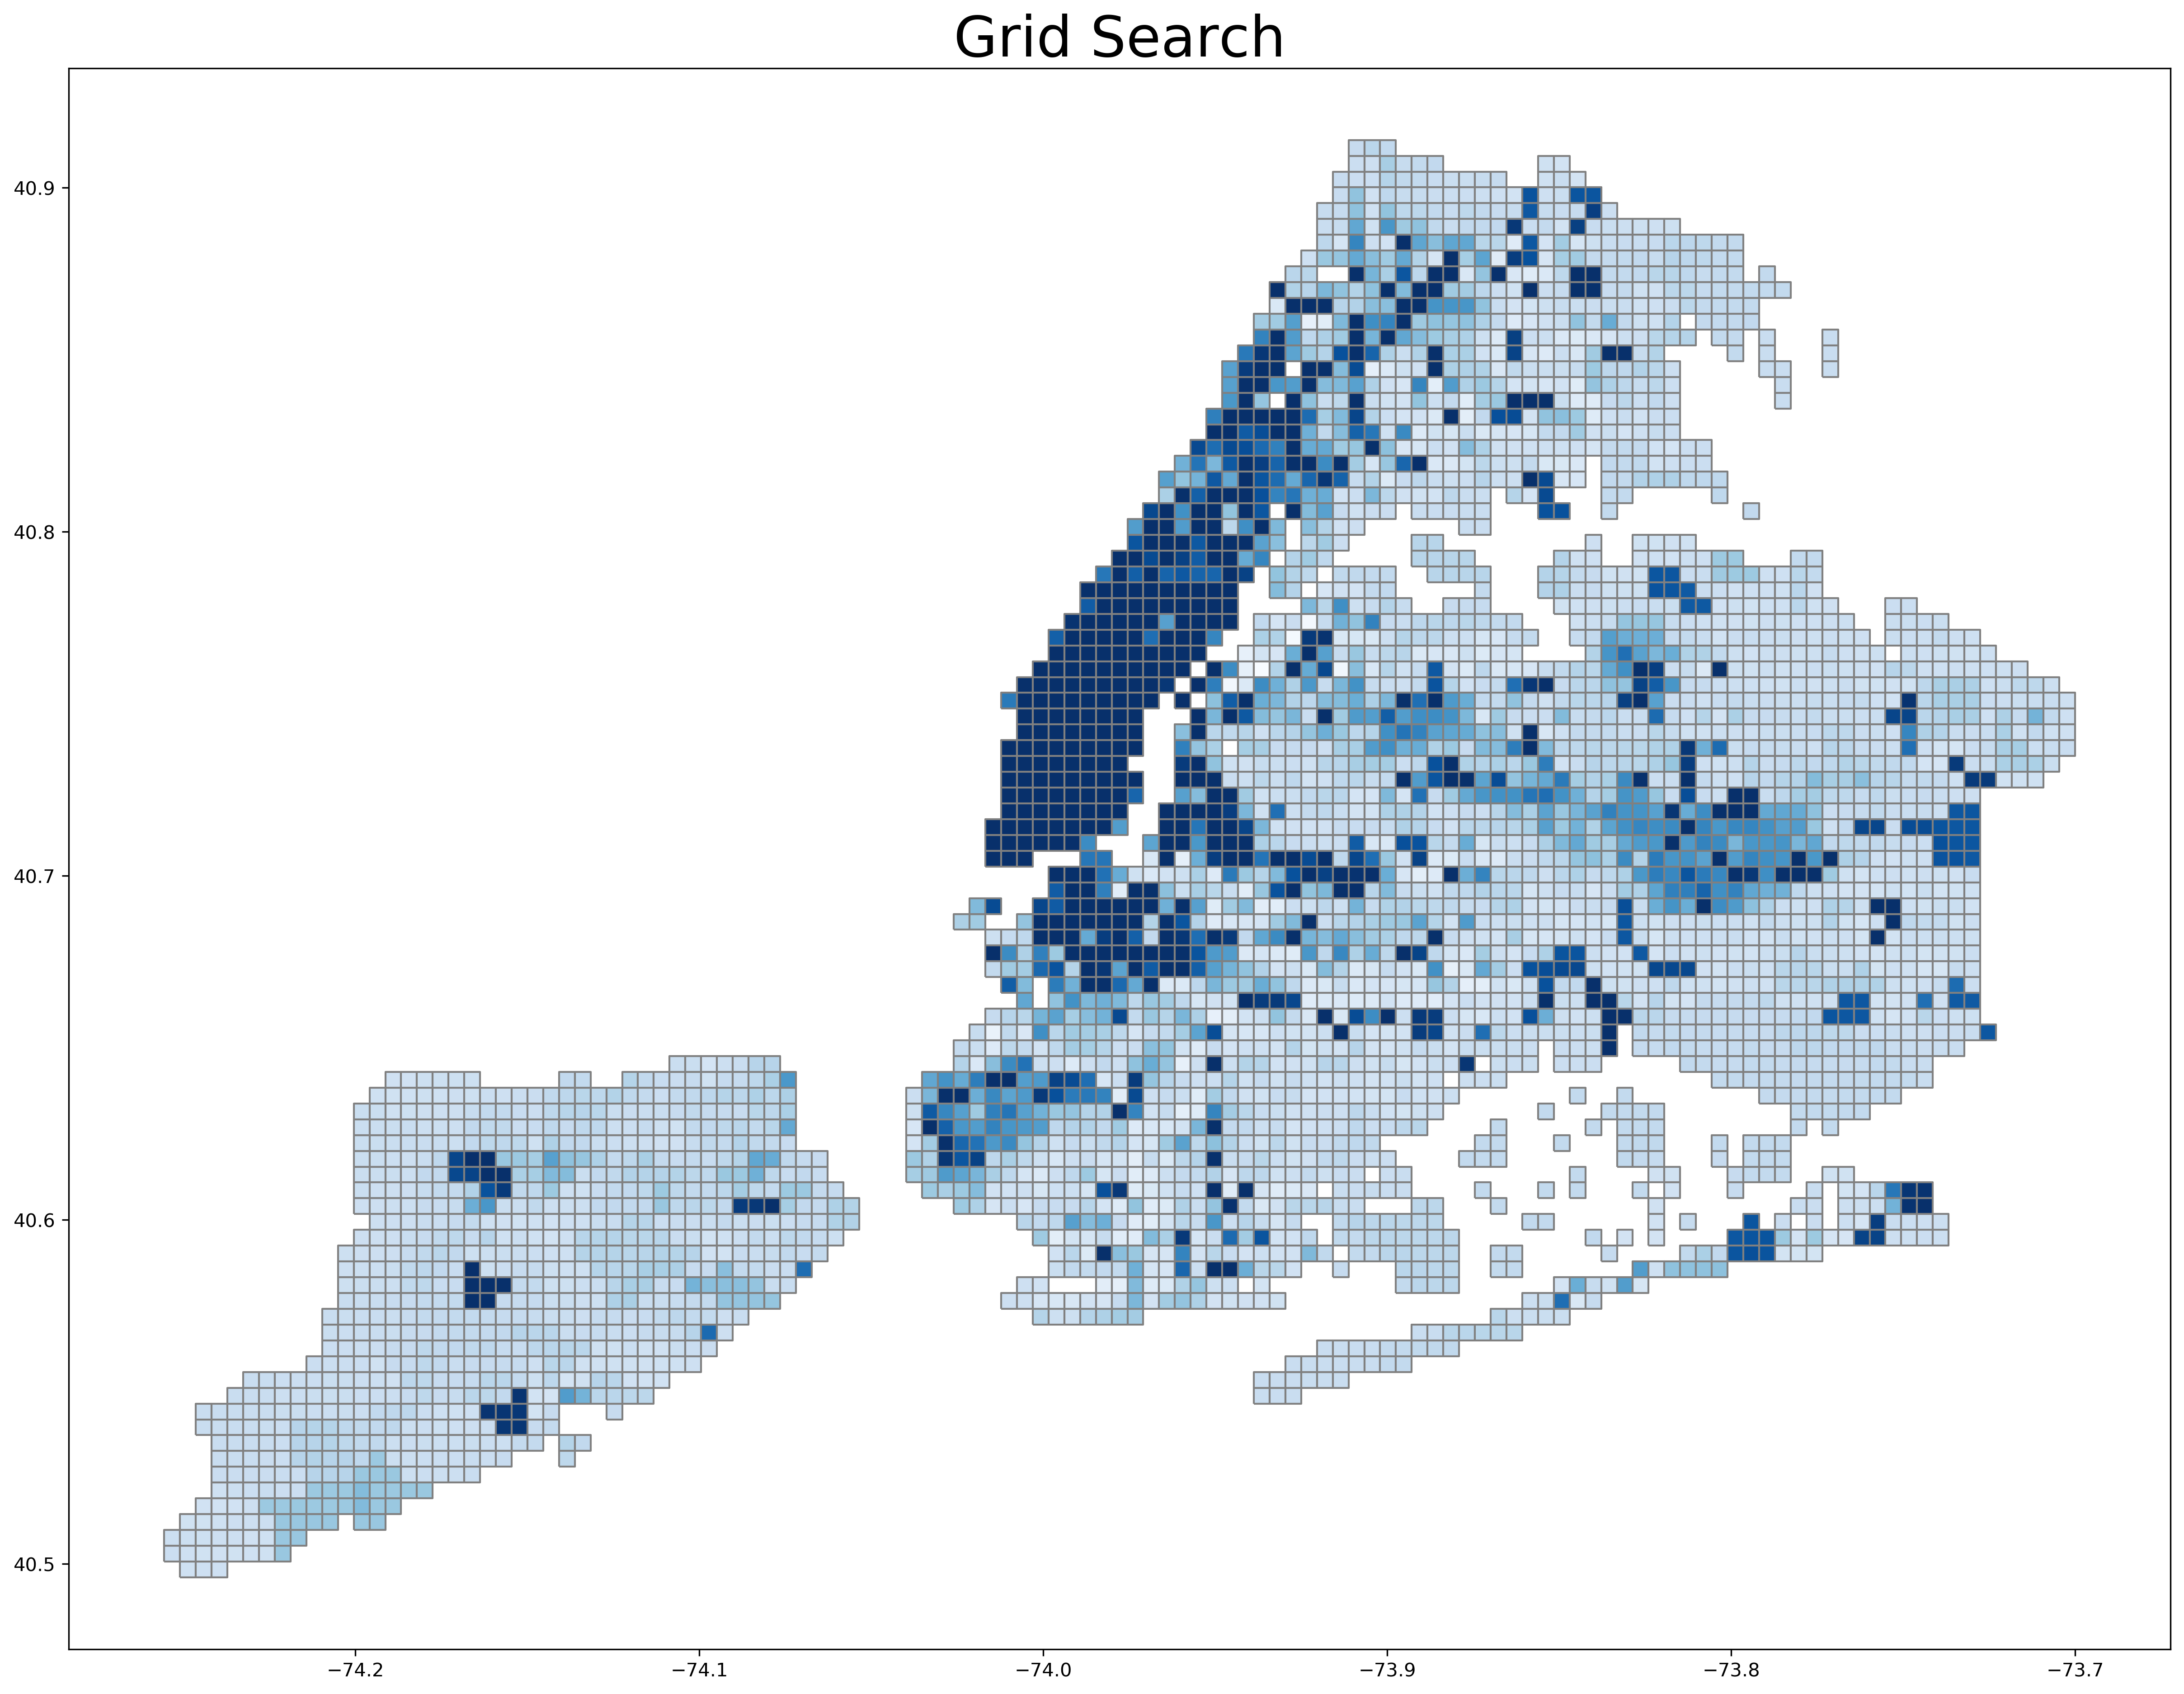

In [39]:
# plot 3
fig, axes = plt.subplots(figsize = (20, 16))

pred_df_yearly_geo.plot(column="new_pred_grid_search", cmap='Blues',edgecolor = "grey", figsize=(12, 10),  
                    legend = False, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = axes, vmax = 25000)
axes.set_title("Grid Search", fontsize=30)
plt.savefig(os.path.join(save_dir_forecast, "FINAL_GS_" + CITY + FIG_NAME))

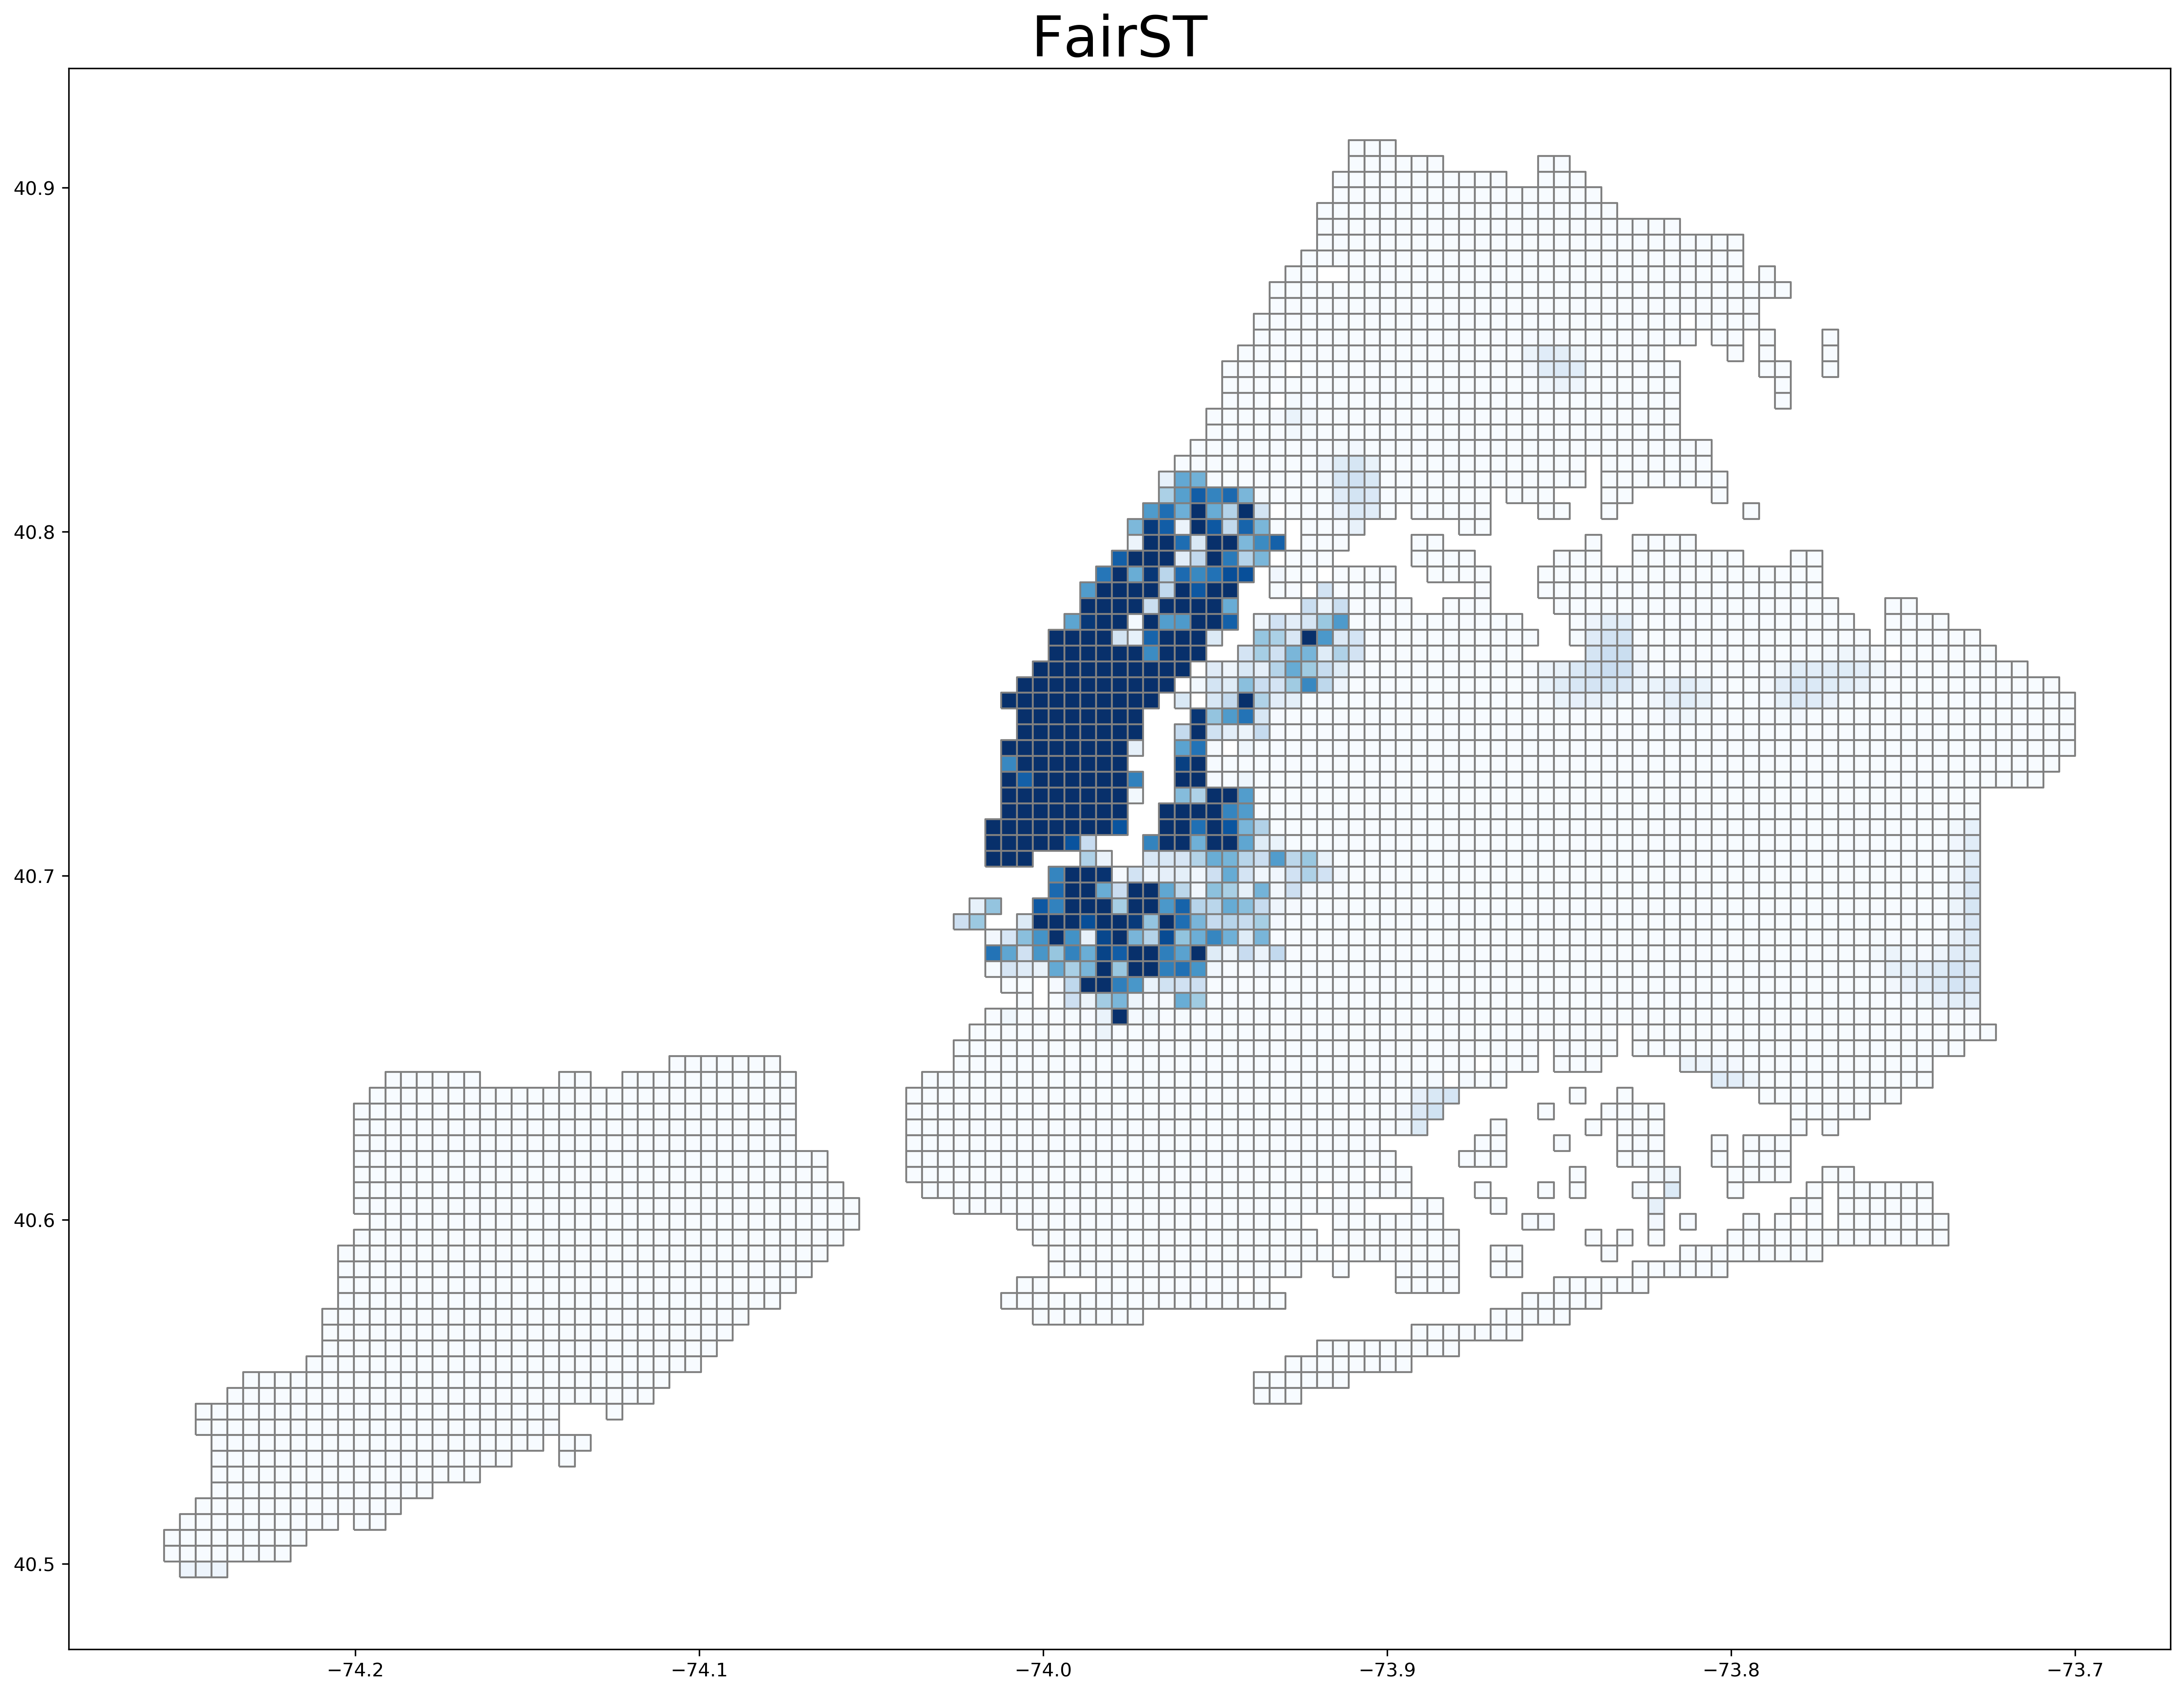

In [40]:
# plot 4
fig, axes = plt.subplots(figsize = (20, 16))

fairst_forecast_inc.plot(column="outflow", cmap='Blues',edgecolor = "grey", figsize=(12, 10),  
                    legend = False, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = axes, vmax = 25000)

axes.set_title("FairST", fontsize=30)
plt.savefig(os.path.join(save_dir_forecast, "FINAL_fairst_" + CITY + FIG_NAME))

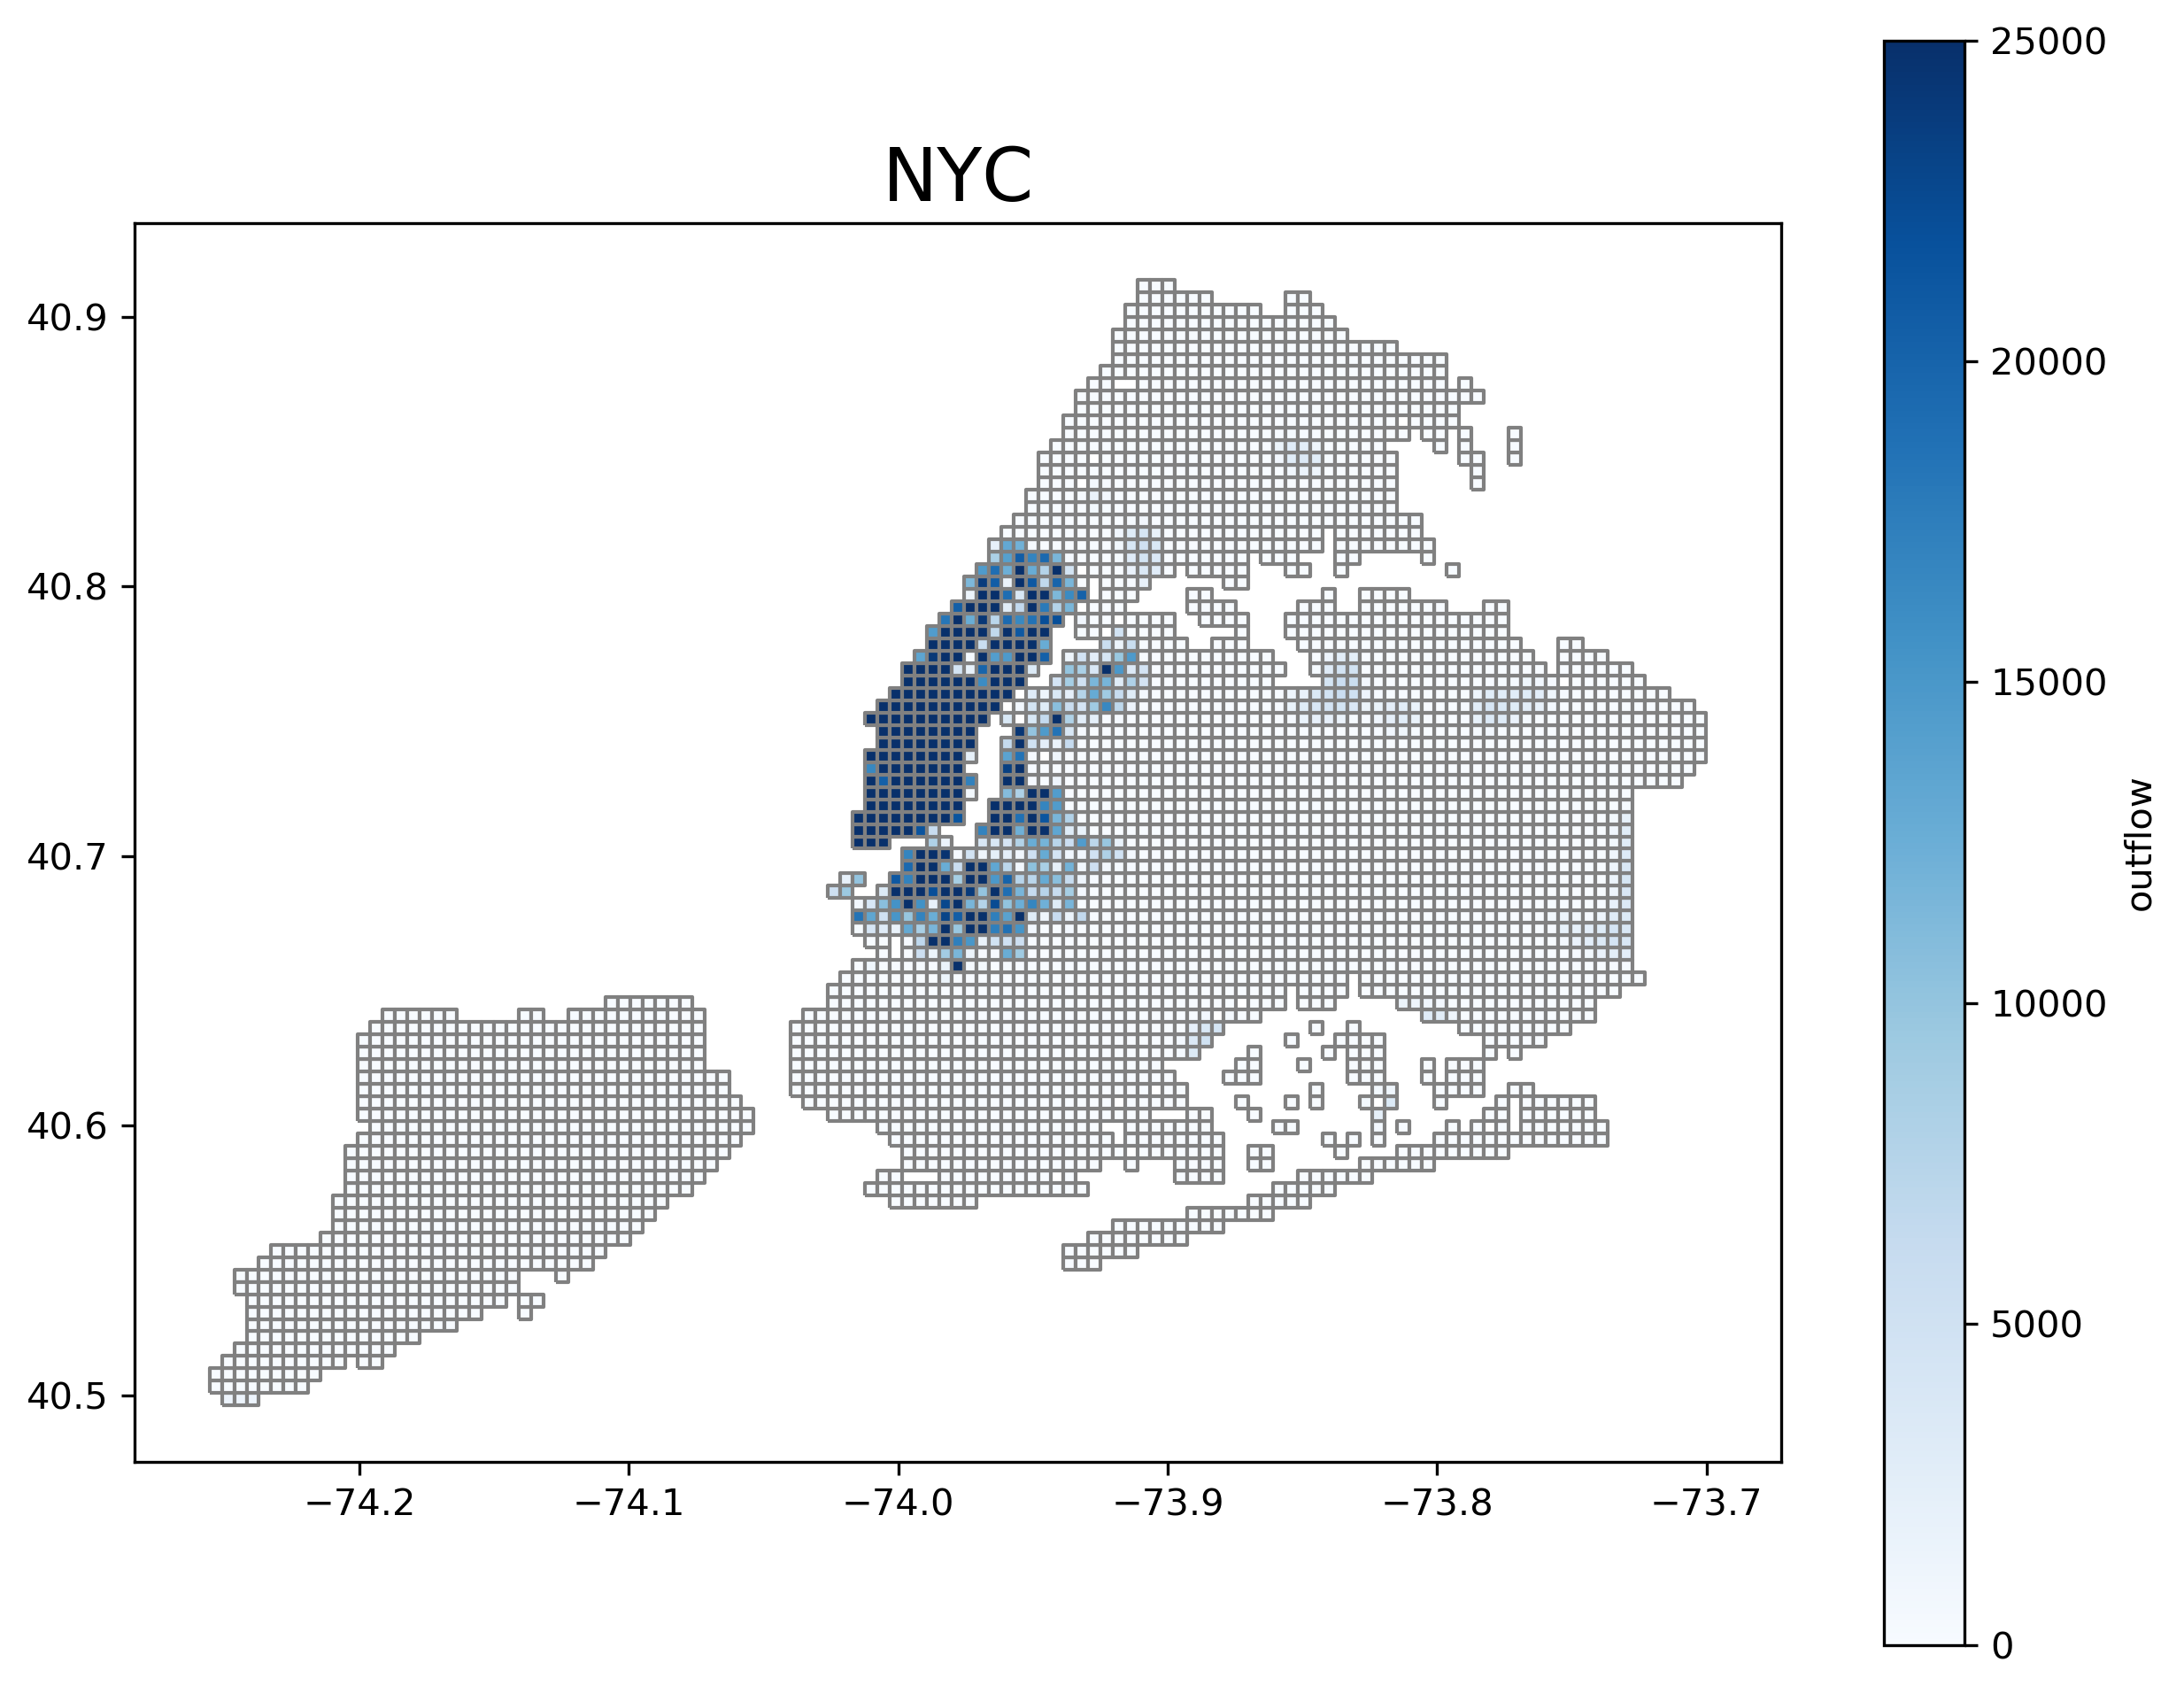

In [41]:
fig, axes = plt.subplots(figsize = (10, 8))

fairst_forecast_inc.plot(column="outflow", cmap='Blues',edgecolor = "grey", figsize=(12, 10),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = axes, vmax = 25000)
axes.set_title("NYC", fontsize=20)
plt.savefig(os.path.join(save_dir_forecast, "color_bar"))

___

### Analyze

In [42]:
def forecast_res_calc(pred_df_yearly_geo):
    
    high_inc = pred_df_yearly_geo[pred_df_yearly_geo["income_group"] == "high_income"]
    low_inc = pred_df_yearly_geo[pred_df_yearly_geo["income_group"] == "low_income"]

    random_forest_diff =  ((low_inc.new_pred_random_forest.sum())/len(low_inc)) / ((high_inc.new_pred_random_forest.sum())/len(high_inc))
    
    
    exp_grad_diff =  ((low_inc.new_pred_exp_grad.sum())/len(low_inc)) / ((high_inc.new_pred_exp_grad.sum())/len(high_inc))
    
    grid_search_diff =  ((low_inc.new_pred_grid_search.sum())/len(low_inc)) / ((high_inc.new_pred_grid_search.sum())/len(high_inc))

    return random_forest_diff, exp_grad_diff, grid_search_diff

In [43]:
FILE_NAME = "forc_res_summary.csv"

PATH1 = os.path.join(save_dir_forecast, CITY + FILE_NAME)

if path.exists(PATH1):
    forc_res_summary = pd.read_csv(PATH1, index_col = 0)
else:
    forc_res_summary = pd.DataFrame(0, columns = ["random_forest_ratio", "exp_grad_ratio", "grid_search_ratio"], index = ["inc_{}_station".format(NUM_STATIONS_INC)])

In [38]:
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "random_forest_ratio"] = forecast_res_calc(pred_df_yearly_geo)[0]
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "exp_grad_ratio"] = forecast_res_calc(pred_df_yearly_geo)[1]
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "grid_search_ratio"] = forecast_res_calc(pred_df_yearly_geo)[2]

In [39]:
fairst_high_inc = fairst_forecast_inc[fairst_forecast_inc["income_group"] == 1]
fairst_low_inc = fairst_forecast_inc[fairst_forecast_inc["income_group"] == 0]
fairst_high_inc_avg = ((fairst_high_inc.outflow.sum())/len(fairst_high_inc))
fairst_low_inc_avg = ((fairst_low_inc.outflow.sum())/len(fairst_low_inc))

fairst_ratio = fairst_low_inc_avg/fairst_high_inc_avg

In [40]:
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "fairst_ratio"] = fairst_ratio

In [41]:
forc_res_summary.to_csv(os.path.join(save_dir_forecast, CITY + FILE_NAME))